In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import re

# 1x3 scatter plots of RF regression results

In [12]:
s1_unit = 'dB'
second_stat = 'max'

metrics_dir = 'output/rf_metrics/single_date'
predict_dir = 'output/rf_predictions/single_date'
metrics_multi_dir = 'output/rf_metrics/multi_date'
predict_multi_dir = 'output/rf_predictions/multi_date'

metrics_0219 = sorted(glob(f'{metrics_dir}/0219/*{s1_unit}*_10m_*.csv'))
predict_0219 = sorted(glob(f'{predict_dir}/0219/*{s1_unit}*_10m_*.csv'))
metrics_0302 = sorted(glob(f'{metrics_dir}/0302/*{s1_unit}*_10m_*csv'))
predict_0302 = sorted(glob(f'{predict_dir}/0302/*{s1_unit}*_10m_*.csv'))
metrics_multi = sorted(glob(f'{metrics_multi_dir}/*{s1_unit}*_10m_*.csv'))
predict_multi = sorted(glob(f'{predict_multi_dir}/*{s1_unit}*_10m_*.csv'))

#fig, ax = plt.subplots(1, 3, figsize=(18,6))

for i in range(len(metrics_0219)):#[26:28]:
    if '_10m_' not in metrics_0219[i]:
        continue
    files_0219 = (metrics_0219[i], predict_0219[i])
    files_0302 = (metrics_0302[i], predict_0302[i])
    files_multi = (metrics_multi[i], predict_multi[i])
    title_prefix = ['Feb 18: ', 'Mar 2: ', 'Both dates: ']
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    j = 0
    for date in [files_0219, files_0302, files_multi]:
        mf = date[0]
        pf = date[1]
        # Set up dataframes
        metrics_df = pd.read_csv(mf, index_col=0)
        metrics_df.index.name = 'run_no'
        predict_df = pd.read_csv(pf, index_col=0)
        predict_df['run_no'] = predict_df['run_no'].astype(int)
        predict_df.index.name = 'sample'
        predict_df.index = predict_df.index % len(predict_df)//100 # reset sample count for each run
        predict_df.index = pd.MultiIndex.from_arrays([predict_df['run_no'], predict_df.index])
        predict_df.drop(columns='run_no', inplace=True)

        # Loop through runs for scatter plot
        
        ax[j].scatter(predict_df['predict'], predict_df['valid'], s=2, marker='.', color='k')
        ax[j].set_xlim(ax[j].get_ylim())
        # ax[j].set_xticks(ax[j].get_yticks())
        ax[j].tick_params(axis='x', labelrotation=90)
        # ax[j].set_xlim(ax[j].get_ylim())
        ax[j].set_xlabel('Measured', fontsize=18, labelpad=12)
        
        ax[j].set_title(f'{title_prefix[j]}Avg R$^2$ = {str(round(metrics_df["r2"].mean(), 2))}', fontsize=20)

        j += 1

        # hbin = ax[1].hexbin(predict_df['predict'], predict_df['valid'], cmap='viridis',
        #                     gridsize=50,
        #                     extent=(ax[0].get_xlim()[0], ax[0].get_xlim()[1], ax[0].get_ylim()[0], ax[0].get_ylim()[1]))
        # cbar = plt.colorbar(hbin, ax=ax[1])
        # ax[1].set_xlim(ax[0].get_xlim())
        # ax[1].set_ylim(ax[0].get_ylim())

    xmin, xmax = ax[0].get_xlim()
    ymin, ymax = ax[0].get_ylim()
    for axx in (ax[1], ax[2]):
        x0, x1 = axx.get_xlim()
        if x0 < xmin:
            xmin = x0
        if x1 > xmax:
            xmax = x1
        y0, y1 = axx.get_ylim()
        if y0 < ymin:
            ymin = y0
        if y1 > ymax:
            ymax = y1
    for axx in ax.flatten():
        axx.set_xlim(xmin, xmax)
        axx.set_ylim(ymin, ymax)
        axx.plot((axx.get_xlim()), (axx.get_ylim()), 'r--')
    
    ax[0].set_ylabel('Predicted', fontsize=18, labelpad=12)
    # check for specified scale in filename
    if not re.findall(r'_\d{1,2}[a-z]{1,2}_', mf):
        # Scale not specified (10m pixels)
        fig.suptitle('RF target: 10 m ' + mf.split('_dB_')[-1][:-4], fontsize=22)
    else:
        fig.suptitle('RF target: ' + mf.split('_dB_')[-1][:-4], fontsize=22)
    
    
    fig.tight_layout()
    fig_fname = f"output/figures/scatter/{mf.split('/')[-1].split('.')[0]}.png"
    fig.savefig(fig_fname, dpi=300, facecolor='white')
    plt.close('all')

# Heatmaps of r^2 results

In [ ]:
s1_unit = 'dB'
second_stat = 'mean'

metrics_dir = 'output/rf_metrics/single_date'
predict_dir = 'output/rf_predictions/single_date'
metrics_multi_dir = 'output/rf_metrics/multi_date'
predict_multi_dir = 'output/rf_predictions/multi_date'

metrics_0219 = sorted(glob(f'{metrics_dir}/0219/*{s1_unit}*.csv'))
predict_0219 = sorted(glob(f'{predict_dir}/0219/*{s1_unit}*.csv'))
metrics_0302 = sorted(glob(f'{metrics_dir}/0302/*{s1_unit}*.csv'))
predict_0302 = sorted(glob(f'{predict_dir}/0302/*{s1_unit}*.csv'))
metrics_multi = sorted(glob(f'{metrics_multi_dir}/*{s1_unit}*.csv'))
predict_multi = sorted(glob(f'{predict_multi_dir}/*{s1_unit}*.csv'))

zonal_0219 = [f for f in metrics_0219 if 'zonal' in f]
zonal_0302 = [f for f in metrics_0302 if 'zonal' in f]
subset_0219 = [f for f in zonal_0219 if second_stat in f.split('.')[0].split('_')[-1]]
subset_0302 = [f for f in zonal_0302 if second_stat in f.split('.')[0].split('_')[-1]]

ind = ['10m','5m','2m','1m','50cm','25cm']
cols = ['max','med','min','p5','p95','range']
df_0219 = pd.DataFrame(index=ind, columns=cols, dtype=float)
df_0302 = pd.DataFrame(index=ind, columns=cols, dtype=float)
df_multi = pd.DataFrame(index=ind, columns=cols, dtype=float)

# Add in 10m filenames
files_10m_0219 = [f'{metrics_dir}/0219/func_test_{s1_unit}_zonal_0219_10m_{i}.csv' for i in cols]
files_10m_0302 = [f'{metrics_dir}/0302/func_test_{s1_unit}_zonal_0304_10m_{i}.csv' for i in cols]
subset_0219 = files_10m_0219 + subset_0219
subset_0302 = files_10m_0302 + subset_0302


def single_to_multi(s):
    parts = s.split(re.findall(r'_\d{4}', s)[0])
    full = parts[0] + parts[1]
    full = full.replace(re.findall(r'/\d{4}', full)[0], '')
    full = full.replace('single', 'multi')
    return full

subset_multi = [single_to_multi(f) for f in subset_0219]


for f0219, f0302, fmulti in zip(subset_0219, subset_0302, subset_multi):
    data_0219 = pd.read_csv(f0219, index_col=0)
    data_0302 = pd.read_csv(f0302, index_col=0)
    data_multi = pd.read_csv(fmulti, index_col=0)
    r2_0219 = data_0219['r2'].mean()
    r2_0302 = data_0302['r2'].mean()
    r2_multi = data_multi['r2'].mean()
    scale = re.findall(r'_\d{1,2}[a-z]{1,2}_', f0219)[0].split('_')[1]
    if scale == '10m':
        stat = f0219.split('_')[-1].split('.')[0]
    else:
        stat = f0219.split('_')[-2]
    df_0219.loc[scale, stat] = r2_0219
    df_0302.loc[scale, stat] = r2_0302
    df_multi.loc[scale, stat] = r2_multi
    
    
cmap = plt.get_cmap('YlGn')#.set_bad('#ff9696')
vmin = 0
vmax = 0.6

dfs = [df_0219, df_0302, df_multi]
titles = ['Feb 18 S1 data/Feb 19 UAV data', 'Mar 2 S1 data/Mar 4 UAV data', 'Combined dates']
fig, ax = plt.subplots(1, len(dfs), figsize=(9*len(dfs),10))
fig.suptitle(f'Final UAV summary statistic: {second_stat}', fontsize=24, y=0.95)
j = 0

for df in dfs:
    im = ax[j].imshow(df, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[j].set_xticks(np.arange(df.shape[1]+1)-.5, minor=True)
    ax[j].set_yticks(np.arange(df.shape[0]+1)-.5, minor=True)
    ax[j].grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax[j].tick_params(axis='both', which='minor', bottom=False, left=False)
    ax[j].set_xticks(ax[j].get_xticks()[1:-1])
    ax[j].set_yticks(ax[j].get_yticks()[1:-1])
    ax[j].set_xticklabels(cols, fontsize=16)
    ax[j].set_yticklabels(ind, fontsize=16)
    cbar_ratio = df.shape[0]/df.shape[1]
    cbar = plt.colorbar(im, ax=ax[j], fraction=0.046*cbar_ratio, pad=0.04)
    cbar.ax.tick_params(labelsize=18)
    if j == len(dfs)-1:
        cbar.ax.set_ylabel('Average $R^2$ of 100 RF runs', rotation=-90, 
                           va='bottom', fontsize=20, labelpad=12)
        

    for i in range(len(ind)):
        for k in range(len(cols)):
            text = ax[j].text(k, i, df.iloc[i, k].round(2), fontsize=16,
                        ha='center', va='center', color='k')

    ax[j].spines['bottom'].set_visible(False)
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['left'].set_visible(False)
    ax[j].spines['right'].set_visible(False)

    ax[j].set_xlabel('UAV pixel summary statistic', fontsize=20, labelpad=14)
    if j == 0:
        ax[j].set_ylabel('UAV subgrid scale', fontsize=20, labelpad=12)


    ax[j].set_title(titles[j], fontsize=20)
    j += 1
        
plt.tight_layout()

fig.savefig(f'output/figures/heatmap/full_comparison_{second_stat}_{s1_unit}.png', 
            facecolor='white', dpi=300)
    


# Distributions of roughness measurements

In [11]:
dir_0218 = 'input_data/s1_pixels/0218/'
dir_0302 = 'input_data/s1_pixels/0302/'

first_loop = True
bins = np.logspace(-4, 0, 200)

i = 0
for d in [dir_0218, dir_0302]:
    for f in sorted(glob(f'{d}*.csv')):
        data = pd.read_csv(f, index_col=0, na_values=[0])
        data.dropna(inplace=True)
        data.reset_index(inplace=True)
        binned = pd.cut(data['std_dev'], bins=bins, precision=6)
        counts = binned.value_counts().sort_index()
        
        if first_loop:
            counts_0218 = pd.Series(np.zeros(len(counts)),
                                    index=counts.index, dtype=int)
            counts_0302 = pd.Series(np.zeros(len(counts)),
                                    index=counts.index, dtype=int)
            
            first_loop = False
        
        if i == 0:
            counts_0218 += counts
        else:
            counts_0302 += counts   
        
    i += 1

all_counts = counts_0218 + counts_0302
    # fig, ax = plt.subplots()
    # ax.bar(bins[:-1], all_counts, width=np.diff(bins)*0.8)
    # ax.set_xscale('log')
    # ax.set_xticks([0.0001, 0.001, 0.01, 0.1, 1])
        



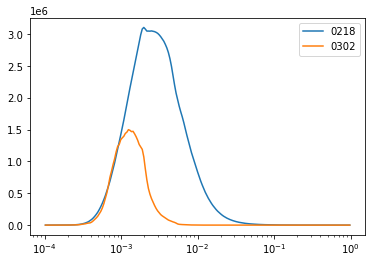

In [12]:
bins_center = (bins[1:] + bins[:-1])/2

# fig, ax = plt.subplots(figsize=(30,10))
# ax.bar(bins[:-1], all_counts, width=np.diff(bins)*0.8)
# ax.set_xscale('log')
# ax.set_xlim(0.0001, 1)
# ax.set_xticks([0.0001, 0.001, 0.01, 0.1, 1])

fig, ax = plt.subplots()
ax.plot(bins_center, counts_0218, label='0218')
ax.plot(bins_center, counts_0302, label='0302')
ax.set_xscale('log')
ax.legend()

In [14]:
counts_0302.sum() - counts_0218.sum()

-96251520